In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [124]:
VIDEOS = Path('videos')

In [2]:
import os

In [3]:
import sys
sys.path.append('../')
import timing
from pathlib import Path

In [4]:
import xarray as xr
import numpy as np
import pandas as pd

In [138]:
from tqdm import tqdm

In [88]:
from datetime import datetime, timedelta

In [5]:
from importlib import reload

In [6]:
from utils import ALL_SATS, remap_fast_mean

In [7]:
import os

In [8]:
from make_index import get_index_bands

In [9]:
from make_sample import open_index, band_dir_path, read_scene

In [10]:
import satpy

In [126]:
sys.path.append('/ships19/cloud/scratch/cphillips/utility/')
import make_gif

In [11]:
os.environ['XRIT_DECOMPRESS_PATH'] = str(Path('../xrit/PublicDecompWT/xRITDecompress/xRITDecompress').absolute())

In [105]:
COMP_CACHE = Path('../composite_cache/')
INDEX = Path('../index')
L1B_DIR = Path('../l1b')
ABI_SCAN_DIR = Path('../ancil/abi_scan_schedule/')

In [193]:
dt = pd.to_datetime('2020-07-01')

wmo_ids = xr.open_dataset(COMP_CACHE / 'wmo_id.nc').wmo_id
sample_mode = xr.open_dataset(COMP_CACHE / 'sample_mode.nc').sample_mode

grid_shape = wmo_ids.shape

In [225]:
composite = xr.DataArray(np.full(grid_shape, np.nan, dtype=np.float32), dims=['layer','latitude','longitude'])

for attrs in ALL_SATS[:]:
    print(attrs['name'])
    _,index_band = max(get_index_bands(attrs['res']).items())

    src_index, dst_index, src_index_nn, dst_index_nn = open_index(INDEX, attrs['sat'], index_band)

    band_dir = band_dir_path(L1B_DIR, dt, attrs['sat'], 'temp_11_00um')

    files = list(band_dir.glob('*'))
    v, area = read_scene(files, attrs['reader'])

    reload(timing)

    if attrs['reader'] == 'seviri_l1b_hrit':
        start_time, line_times = timing.meteosat_get_time_offset(v)
        offsets = timing.meteosat_estimate_pixel_time_offsets(line_times)

    elif attrs['reader'] == 'ahi_hsd':
        start_time, line_times = timing.himawari_line_times(files)
        offsets = timing.himawari_estimate_pixel_time_offsets(line_times)

    elif attrs['reader'] == 'abi_l1b':
        offsets = timing.goes_pixel_time_offset(ABI_SCAN_DIR)
        start_time = timing.goes_start_time(files)
    adjust = (start_time - dt).total_seconds()
    offsets += adjust

    print('remap')
    out_nn = remap_fast_mean(src_index_nn, dst_index_nn, offsets, grid_shape[-2:])

    print('composite')
    for layer in range(composite.shape[0]):
        mask = (wmo_ids[layer].values  == attrs['wmo_id'])
        composite.values[layer, mask] = out_nn[mask]

GOES-16
remap
composite
GOES-17
remap
composite
Himawari-8
remap
composite
Meteosat-8
remap
composite
Meteosat-11
remap
composite


In [226]:
end_s = composite.max()+10
start_s = min(composite.min().item(), 0)

In [227]:
import PIL.Image

In [228]:
cache = COMP_CACHE / dt.strftime('%Y') / dt.strftime('%Y%m') / dt.strftime('%Y%m%d') / dt.strftime('%Y%m%dT%H%M') / 'temp_11_00um.nc'

In [229]:
bt11 = xr.open_dataset(cache).temp_11_00um.values

In [323]:
last_t = 0
canvas = np.zeros((*grid_shape[-2:],3), dtype=np.uint8)
video = VIDEOS / 'test_timing.mp4'
with make_gif.make_video(video, framerate=30) as vid:
    with tqdm(np.arange(start_s, end_s, 3.33)) as bar:
        for t in bar:
            mask = (composite.values >= last_t) & (composite.values< t)
            mask_any = mask.any(axis=0)
            canvas[mask_any,0] = 255
            canvas[mask_any,1] = 0
            canvas[mask_any,2] = 0
            last_t = t
            im = PIL.Image.fromarray(canvas).resize((1024, 512))
            im.save(vid,format='png')
            idx = np.argmax(mask, axis=0)[np.newaxis]
            bt = np.nan_to_num(np.take_along_axis(bt11, idx, axis=0)[0,mask_any], nan=320)
            bt = 255-((bt-160)/(320-160)*255).clip(0,255).astype(np.uint8)
            canvas[mask_any,0] = bt
            canvas[mask_any,1] = bt
            canvas[mask_any,2] = bt

100%|██████████| 229/229 [01:33<00:00,  2.46it/s]


In [324]:
make_gif.play_video(video)

In [326]:
video.stat().st_size/1e6

0.450823

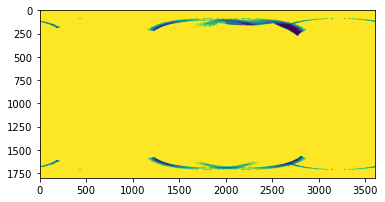

In [297]:
imshow((wmo_ids[0] != 0) == np.isfinite(bt11[0]))

<ipython-input-316-f80a39e4fd4c>:2: RuntimeWarning: All-NaN slice encountered
  imshow(np.nanmin(bt11, axis=0)<159, vmin=0, vmax=1, cmap='viridis')


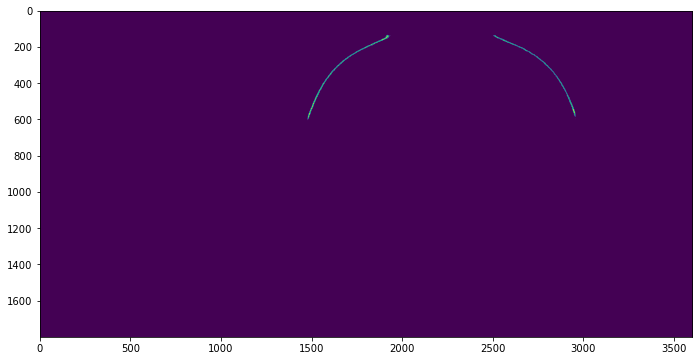

In [316]:
figure(figsize=(12,6))
imshow(np.nanmin(bt11, axis=0)<159, vmin=0, vmax=1, cmap='viridis')

In [320]:
1

1

<ipython-input-321-20117745adb7>:1: RuntimeWarning: All-NaN slice encountered
  hist(np.nanmin(bt11, axis=0).ravel(), range=(140, 170), bins=20);


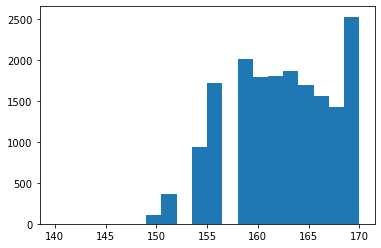

In [321]:
hist(np.nanmin(bt11, axis=0).ravel(), range=(140, 170), bins=20);

<ipython-input-308-800550bd7a61>:2: RuntimeWarning: All-NaN slice encountered
  imshow(np.nanmax(bt11, axis=0), vmin=160, vmax=320, cmap='binary')


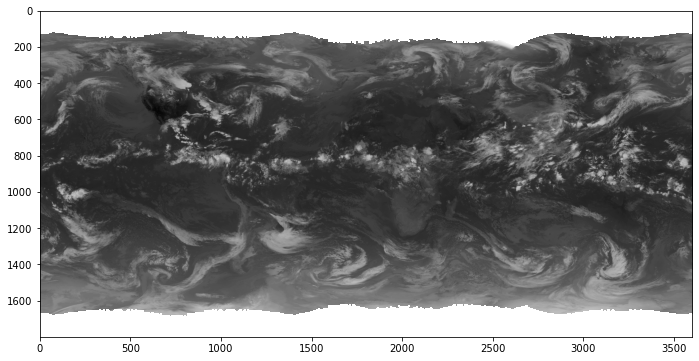

In [308]:
figure(figsize=(12,6))
imshow(np.nanmax(bt11, axis=0), vmin=160, vmax=320, cmap='binary')